In [18]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyart
import zipfile
import datetime as dt
import os
import tqdm
import pandas as pd
import warnings
from metpy.interpolate import cross_section
import h5py
from scipy.interpolate import griddata

warnings.simplefilter("ignore")

def reconstruct_grid(f, group_id):

        #From h5 grid objects (f), reconstruct the radar grid

        bbox = f[group_id].attrs["bbox"]
        x = f["lon/lon"][:]
        y = f["lat/lat"][:]
        recon = np.zeros(x.shape)
        recon[bbox[0]:bbox[2],bbox[1]:bbox[3]] = f[group_id+"/cell_mask"][:]

        return recon, x, y
    
def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01]):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143; max_lon=146; min_lat=-39.5; max_lat=-36.5
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149; max_lon=152; min_lat=-35; max_lat=-32
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151; max_lon=154; min_lat=-29; max_lat=-26
    elif rid=="66":
        min_lon=150; max_lon=155; min_lat=-29; max_lat=-25
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=60)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="x", mew=2, ms=12, color="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (DBZ)")
    return disp
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60*6), time]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    radar_file = pyart.io.read_grid(target_files[0])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file 

def load_radar_range(rid, times):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    out = []
    time_out = []
    for f in tqdm.tqdm(target_files):
            radar_file = pyart.io.read_grid(f).to_xarray().corrected_reflectivity.isel({"time":0}).max("z")
            out.append(radar_file.values)
            time_out.append(radar_file.time.values)
    
    _ = [os.remove(f) for f in target_files]
    
    return out, time_out, radar_file.lon.values, radar_file.lat.values

def preprocess(ds):
    ds = ds.expand_dims({"time":[dt.datetime.strptime(ds.attrs["date"],"%Y-%m-%dT%H:%M:%S")]})
    ds = ds.assign({"ws_surface":np.sqrt((np.square(ds.vx_surface) + np.square(ds.vy_surface)))})
    ds = ds.assign({"ws":np.sqrt((np.square(ds.vx) + np.square(ds.vy)))})
    return ds

def plot_domain(rad_wnd,t,extra_points=False):

    plt.figure(figsize=[22,8])

    rad_wnd_lat=rad_wnd.isel({"time":0}).latitude.values
    rad_wnd_lon=rad_wnd.isel({"time":0}).longitude.values

    ax1=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
    c=ax1.pcolormesh(rad_wnd_lon,rad_wnd_lat,rad_wnd.dBZ_radar1.sel({"time":t}).max("z").values,cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    ax1.gridlines(draw_labels=True)
    ax1.coastlines()
    plt.colorbar(c)
    plt.title(t)

    ax2=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
    c=ax2.pcolormesh(rad_wnd_lon,rad_wnd_lat,rad_wnd.ws_surface.sel({"time":t}).values,vmin=10,vmax=30)
    ax2.gridlines(draw_labels=True)
    ax2.coastlines()
    plt.colorbar(c)
    plt.title(t)    

    ax3=plt.subplot(1,3,3)
    rad_wnd.ws_surface.max(("x","y")).plot(marker="o")
    ax3.axvline(pd.to_datetime(t),color="k",ls="--")
    
    if extra_points:
        for point in extra_points:
            ax1.plot(point[0],point[1],marker="o",color="k",ms=10,mew=2,mfc="none")
            ax2.plot(point[0],point[1],marker="o",color="k",ms=10,mew=2,mfc="none")
            
def storm_track(rad_wnd, group_id, file_id):
    #Use the storm object of interest (from TINT tracking of level 1b AURA data) to mask the surface wind retrievals

    #Load the storm ID for the event of interest, and use that to get group ids over the storm lifetime    
    uid = str(group_id.split("/")[1])
    storm_df = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+file_id+".csv").query("uid=="+uid)
    storm_df["group_id"] = pd.DatetimeIndex(storm_df["time"]).strftime("%Y%m%d%H%M%S") + "/" + storm_df["uid"].astype(str)

    #Load the H5 grids for the storm of interest
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")

    #Set up for interpolation, from the radar wind retreival grid to the level1b AURA grid
    rad_wnd_lat=rad_wnd.isel({"time":0}).latitude.values
    rad_wnd_lon=rad_wnd.isel({"time":0}).longitude.values    
    obj_sfc_wind = []
    rad_wnd_time = []
    print(storm_df.shape[0]," time steps")
    for g, time in tqdm.tqdm(zip(storm_df["group_id"],storm_df["time"])):
        r,x,y = reconstruct_grid(grid,g)   
        points = np.stack([x.flatten(), y.flatten()]).T
        xi = np.stack([rad_wnd_lon.flatten(), rad_wnd_lat.flatten()]).T
        values = r.flatten()
        values_i = griddata(points, values, xi, method="nearest").reshape(rad_wnd_lon.shape)
        temp = rad_wnd.interp({"time":time},method="nearest")
        obj_sfc_wind.append(temp.ws_surface.where(values_i).values)
        rad_wnd_time.append(temp.time.values)

    #Plot the masked, surface wind retrievals for the parent storm lifetime. Compare to the measured SCW gust from AWS
    plt.figure(figsize=[16,8])
    plt.plot(rad_wnd_time,np.nanmax(np.stack(obj_sfc_wind),axis=(1,2)),label="Surface wind retrieval",marker="o")

    print("Loading AWS data...")
    aws_uid=pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+file_id+"_aws.csv").query("(uid10=="+uid+") & (in10km==1)")
    aws_uid.set_index(pd.DatetimeIndex(aws_uid.dt_utc)).sort_values("gust",ascending=False).drop_duplicates("stn_id").gust.plot(\
                        marker="x",color="k",ms=10,mew=3,label="Measured AWS gust\n(max at each AWS that are\nwithin 10 km of storm)",ls="none")

    plt.gca().grid(ls="--")

    plt.title("Max surface wind retrievals applying SCW parent storm object mask")
    plt.ylabel("Surface wind retrieval (m/s)")
    plt.xlabel("Time (UTC)")
    plt.legend()          
    
def get_xlabs(cross):
    lon_str = cross.lon.values.round(2).astype(str)
    lat_str = cross.lat.values.round(2).astype(str)
    xlab = [i + ", " + j for i, j in zip(lat_str,lon_str)]
    return xlab    

def cross_section_plot(rad_wnd, t, start, end, extra_points=False, preview_transect=False, storm_speed=False, ymax=10):

    #Plot the transect that has been given, on top of column max reflectivity
    
    plt.figure(figsize=[20,10])
    rad_wnd_lat=rad_wnd.isel({"time":0}).latitude.values
    rad_wnd_lon=rad_wnd.isel({"time":0}).longitude.values    
    ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
    c=ax.pcolormesh(rad_wnd_lon,rad_wnd_lat,rad_wnd.dBZ_radar1.sel({"time":t}).max("z").values,cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    plt.colorbar(c)
    ax.set_xlim([start[1]-1,end[1]+1])
    ax.set_ylim([start[0]-1,end[0]+1])
    ax.plot([start[1],end[1]],[start[0],end[0]],color="tab:blue",lw=3)
    ax.coastlines()
    rad_wnd.sel({"time":t}).coarsen(dim={"x":5,"y":5},boundary="trim").mean().plot.quiver("longitude","latitude","vx_surface","vy_surface",ax=ax)
    if extra_points:
        for point in extra_points:
            ax.plot(point[0],point[1],marker="o",color="k",ms=10,mew=2,mfc="none")
            
    ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
    c=ax.pcolormesh(rad_wnd_lon,rad_wnd_lat,rad_wnd.ws_surface.sel({"time":t}).values,vmin=10,vmax=30)
    plt.colorbar(c)    
    ax.set_xlim([start[1]-1,end[1]+1])
    ax.set_ylim([start[0]-1,end[0]+1])
    ax.plot([start[1],end[1]],[start[0],end[0]],color="tab:blue",lw=3)
    ax.coastlines()
    rad_wnd.sel({"time":t}).coarsen(dim={"x":5,"y":5},boundary="trim").mean().plot.quiver("longitude","latitude","vx_surface","vy_surface",ax=ax)
    if extra_points:
        for point in extra_points:
            ax.plot(point[0],point[1],marker="o",color="k",ms=10,mew=2,mfc="none")            
    
    if preview_transect:
        return
    
    #For cross-sectioning, the data needs to be on a regular lat-lon grid (rather than curvilinear grid).
    #Regrid the curvilnear (wind retrieval) grid to regular (from level 1b data) grid
    #This requires loading level 1b radar data for the same radar id
    print("Re-gridding to regular lat-lon for each vertical level...")
    radar=load_radar(rad_wnd.attrs["region_ids"],dt.datetime.strptime(t,"%Y-%m-%d %H:%M:%S"))
    lon_reg = radar.to_xarray().lon
    lat_reg = radar.to_xarray().lat
    lon_reg, lat_reg = np.meshgrid(lon_reg, lat_reg)

    points = np.stack([rad_wnd_lon.flatten(), rad_wnd_lat.flatten()]).T
    xi = np.stack([lon_reg.flatten(), lat_reg.flatten()]).T
    refl_i = []
    vx_i = []
    vy_i = []
    vz_i = []
    ws_i = []
    for i in tqdm.tqdm(rad_wnd.z.values):
        refl = rad_wnd.sel({"time":t}).dBZ_radar1.isel({"z":i}).values.flatten()
        refl_i.append(griddata(points, refl, xi, method="nearest").reshape(lon_reg.shape))

        vy = rad_wnd.sel({"time":t}).vy.isel({"z":i}).values.flatten()
        vy_i.append(griddata(points, vy, xi, method="nearest").reshape(lon_reg.shape))   

        vx = rad_wnd.sel({"time":t}).vx.isel({"z":i}).values.flatten()
        vx_i.append(griddata(points, vx, xi, method="nearest").reshape(lon_reg.shape))       

        vz = rad_wnd.sel({"time":t}).vz.isel({"z":i}).values.flatten()
        vz_i.append(griddata(points, vz, xi, method="nearest").reshape(lon_reg.shape))       

        ws = rad_wnd.sel({"time":t}).ws.isel({"z":i}).values.flatten()
        ws_i.append(griddata(points, ws, xi, method="nearest").reshape(lon_reg.shape))    
        
        
    #Use Metpy to do the cross-sectioning
    cross_refl=cross_section(\
        xr.DataArray(data=refl_i,dims=["z","lat","lon"],
                     coords={"z":rad_wnd.sel({"time":t}).height.values,
                             "lon":radar.to_xarray().lon.values,
                             "lat":radar.to_xarray().lat.values}).\
        metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
        ),
                  start,end,steps=50)

    cross_vy=cross_section(\
        xr.DataArray(data=vy_i,dims=["z","lat","lon"],
                     coords={"z":rad_wnd.sel({"time":t}).height.values,
                             "lon":radar.to_xarray().lon.values,
                             "lat":radar.to_xarray().lat.values}).\
        metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
        ),
                  start,end,steps=50)

    cross_vx=cross_section(\
        xr.DataArray(data=vx_i,dims=["z","lat","lon"],
                     coords={"z":rad_wnd.sel({"time":t}).height.values,
                             "lon":radar.to_xarray().lon.values,
                             "lat":radar.to_xarray().lat.values}).\
        metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
        ),
                  start,end,steps=50)

    cross_vz=cross_section(\
        xr.DataArray(data=vz_i,dims=["z","lat","lon"],
                     coords={"z":rad_wnd.sel({"time":t}).height.values,
                             "lon":radar.to_xarray().lon.values,
                             "lat":radar.to_xarray().lat.values}).\
        metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
        ),
                  start,end,steps=50)

    cross_ws=cross_section(\
        xr.DataArray(data=ws_i,dims=["z","lat","lon"],
                     coords={"z":rad_wnd.sel({"time":t}).height.values,
                             "lon":radar.to_xarray().lon.values,
                             "lat":radar.to_xarray().lat.values}).\
        metpy.assign_crs(
        grid_mapping_name='latitude_longitude',
        earth_radius=6371229.0
        ),
                  start,end,steps=50)

    #Rotate the U and V components to align with the tr
    y1=start[0]; y2=end[0]
    x1=start[1]; x2=end[1]
    angle = np.arctan2((x2-x1),(y2-y1))
    cross_vv = np.sin(angle) * cross_vx + np.cos(angle) * cross_vy
    wind_transect = xr.Dataset({"uu":cross_vv,"w":cross_vz*2}).assign_coords({"index":np.arange(cross_vv.shape[1])})
    
    if storm_speed:
        u_storm = storm_speed
    else:
        u_storm = wind_transect.sel({"z":slice(0,6)}).uu.mean()
    wind_transect=wind_transect.assign({"uu_rel":wind_transect.uu - u_storm})    
    
    
    #Plot three panels with reflectivity, wind speed, and vertical velocity
    plt.figure(figsize=[20,4])
    plt.subplot(1,3,1)
    xr.plot.contourf(cross_refl,
        vmin=-10, 
        vmax=70, 
        cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=16)
    plt.ylim([0,ymax])
    plt.xticks(np.arange(0,50,10),get_xlabs(cross_refl)[0::10])
    plt.gca().tick_params(axis="x",rotation=45)

    plt.subplot(1,3,2)
    xr.plot.contourf(cross_ws,levels=21,cmap=plt.get_cmap("Reds"),extend="both")
    plt.ylim([0,ymax])
    plt.xticks(np.arange(0,50,10),get_xlabs(cross_refl)[0::10])
    plt.gca().tick_params(axis="x",rotation=45)

    plt.subplot(1,3,3)
    xr.plot.contourf(cross_vz,levels=10,vmin=-5,vmax=5,cmap=plt.get_cmap("RdBu_r"))
    plt.ylim([0,ymax])
    plt.xticks(np.arange(0,50,10),get_xlabs(cross_refl)[0::10])
    plt.gca().tick_params(axis="x",rotation=45)
    
    
    #Plot reflectivity with wind vectors
    plt.figure(figsize=[20,8])

    plt.subplot(1,2,1)
    xr.plot.contourf(cross_refl,
        vmin=-10, 
        vmax=70, 
        cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=16)
    wind_transect\
            .coarsen(dim={"index":2,"z":1},boundary="trim").mean()\
            .plot.quiver("index","z","uu","w",scale=250)
    xr.plot.contour(cross_vz,levels=[-5,-2,-1,1,2,5],colors="k")
    xr.plot.contour(cross_ws,levels=[20,25,30,35,40],colors="lightgray",linewidths=3)
    plt.ylim([0,ymax])
    plt.xticks(np.arange(0,50,10),get_xlabs(cross_refl)[0::10])
    plt.gca().tick_params(axis="x",rotation=45)

    plt.subplot(1,2,2)
    xr.plot.contourf(cross_refl,
        vmin=-10, 
        vmax=70, 
        cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=16)
    wind_transect\
            .coarsen(dim={"index":2,"z":1},boundary="trim").mean()\
            .plot.quiver("index","z","uu_rel","w",scale=250)
    xr.plot.contour(cross_vz,levels=[-5,-2,-1,1,2,5],colors="k")
    xr.plot.contour(cross_ws,levels=[20,25,30,35,40],colors="lightgray",linewidths=3)
    plt.ylim([0,ymax])
    plt.xticks(np.arange(0,50,10),get_xlabs(cross_refl)[0::10])
    plt.gca().tick_params(axis="x",rotation=45)    
    
    
def preview_storm(group_id,file_id):
    
    plt.figure()
    ax=plt.axes(projection=ccrs.PlateCarree())    
    ax.coastlines()
    
    grid = h5py.File("/g/data/eg3/ab4502/TINTobjects/"+file_id+".h5", "r")
    r,x,y = reconstruct_grid(grid, group_id)
    ax.pcolormesh(x,y,r,cmap=plt.get_cmap("Blues"))
    ax.set_title(group_id)


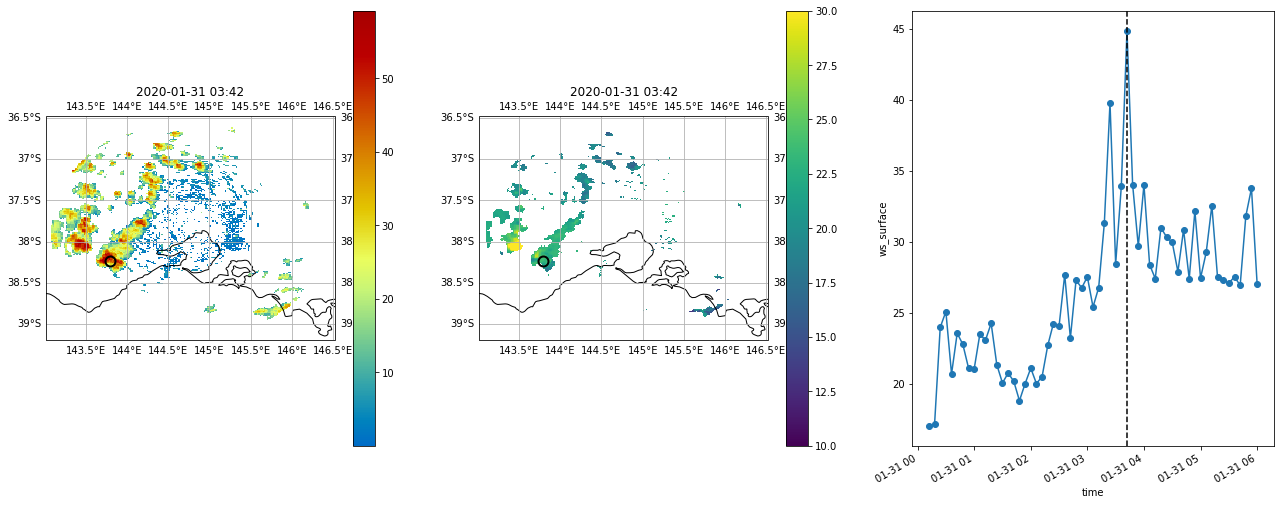

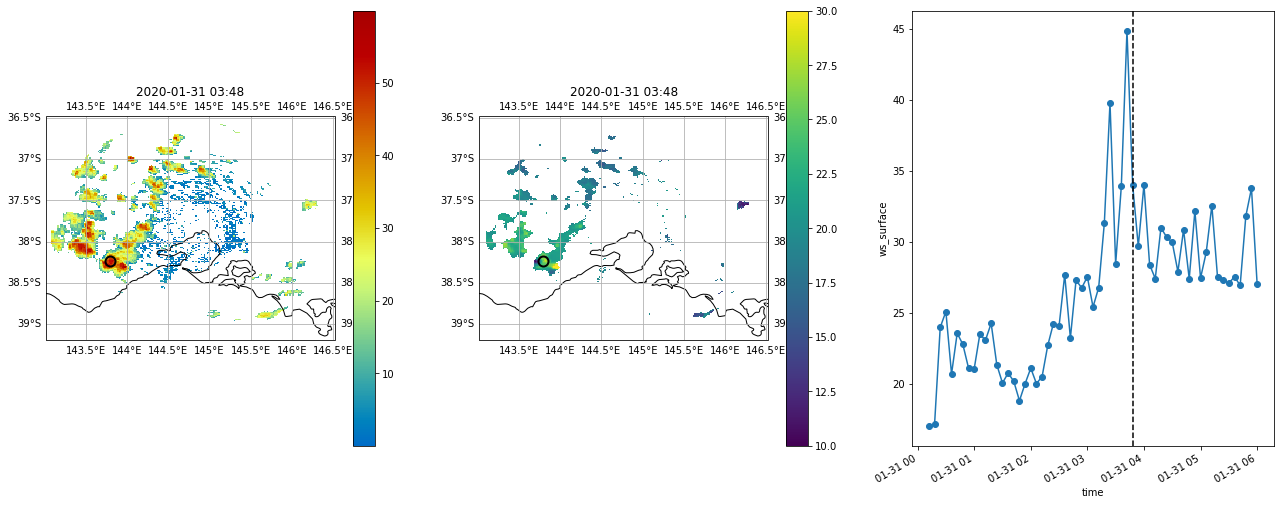

In [21]:
#Load the radar wind retrievals, and plot (reflectivity and surface wind speed) over the domain at a given time. Also, plot a time series of domain-max surface wind speed
rad_wnd = xr.open_mfdataset("/g/data/eg3/ab4502/Andrew_retrievals/20200131/2_20200131_*.nc",preprocess=preprocess)
plot_domain(rad_wnd,"2020-01-31 03:42",[[143.7924,-38.2332]])
plot_domain(rad_wnd,"2020-01-31 03:48",[[143.7924,-38.2332]])

time
2020-01-31 03:42:28    1287
2020-01-31 03:42:28    1299
2020-01-31 03:42:28    1306
2020-01-31 03:42:28    1300
2020-01-31 03:42:28    1304
Name: uid, dtype: int64


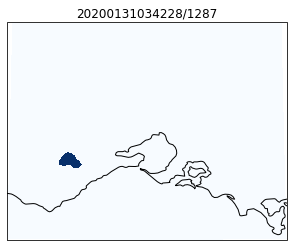

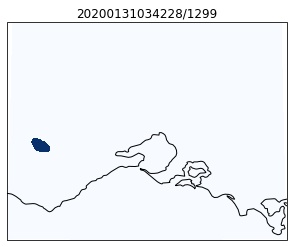

In [22]:
file_id = "2_20200101_20200131"
temp = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+file_id+".csv")
print(temp.set_index(pd.DatetimeIndex(temp.time)).loc["2020-01-31 03:42"].uid)
preview_storm("20200131034228/1287",file_id)
preview_storm("20200131034228/1299",file_id)


In [23]:
#Get the storm details from SCW dataset
pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/2_scw_envs_df.csv").loc[78][["stn_id","gust","dt_utc","group_id","speed"]]

stn_id                    90035
gust                       33.1
dt_utc      2020-01-31 03:47:00
group_id    20200131034228/1287
speed                    23.659
Name: 78, dtype: object

27  time steps


27it [00:07,  3.52it/s]


Loading AWS data...


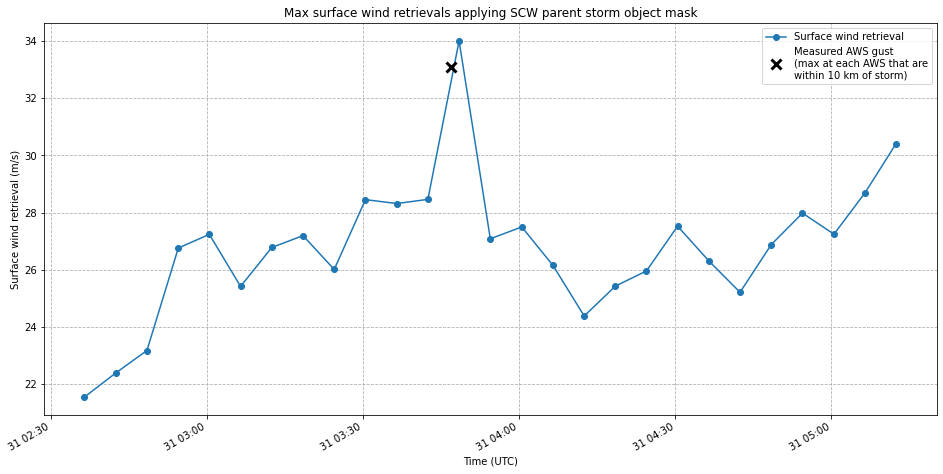

In [24]:
#For a particular storm tracked by TINT, represented as a group_id, plot a time series of maximum surface wind speed masked by the TINT object
#This also loads all AWS data, and plots the maximum observed at each station for which the same TINT object is within 10 km
group_id = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/2_scw_envs_df.csv").loc[78]["group_id"]
storm_track(rad_wnd,group_id,file_id)

8  time steps


8it [00:02,  3.25it/s]


Loading AWS data...


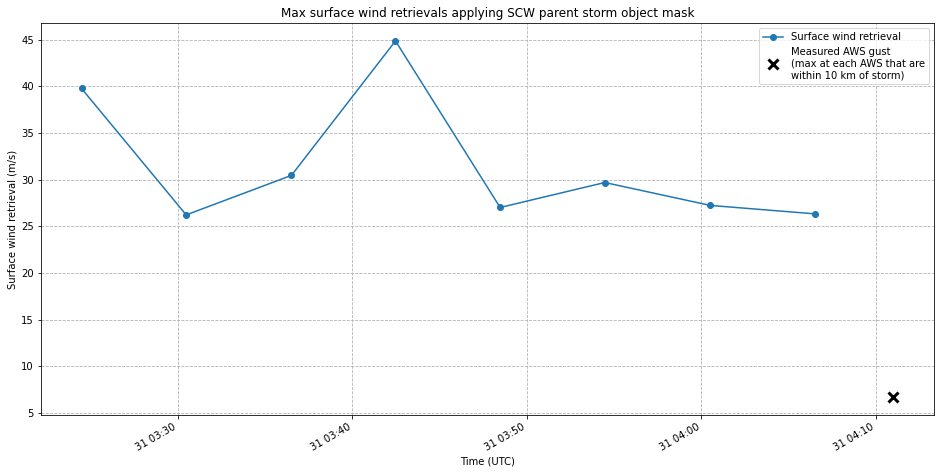

In [25]:
#For a particular storm tracked by TINT, represented as a group_id, plot a time series of maximum surface wind speed masked by the TINT object
#This also loads all AWS data, and plots the maximum observed at each station for which the same TINT object is within 10 km
group_id = "20200131034228/1299"
file_id = "2_20200101_20200131"
storm_track(rad_wnd,group_id,file_id)

Re-gridding to regular lat-lon for each vertical level...


100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


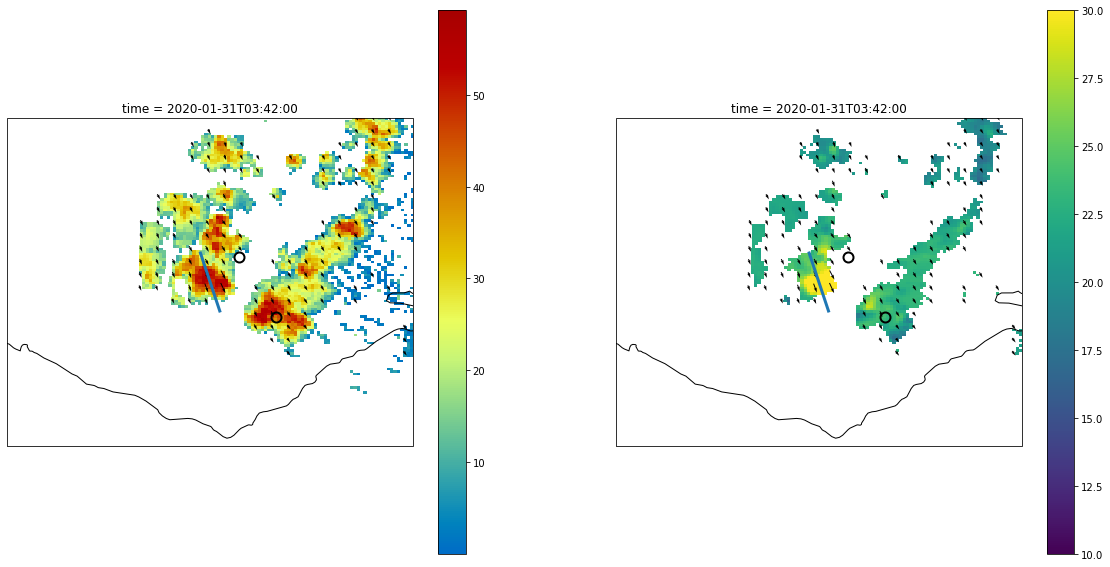

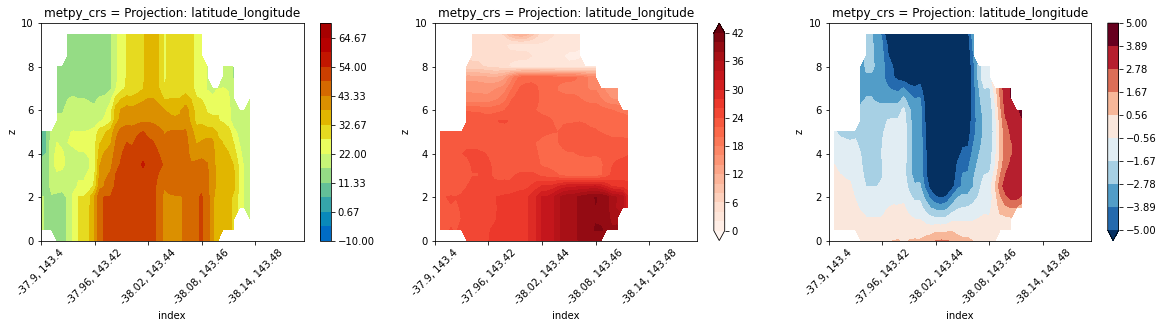

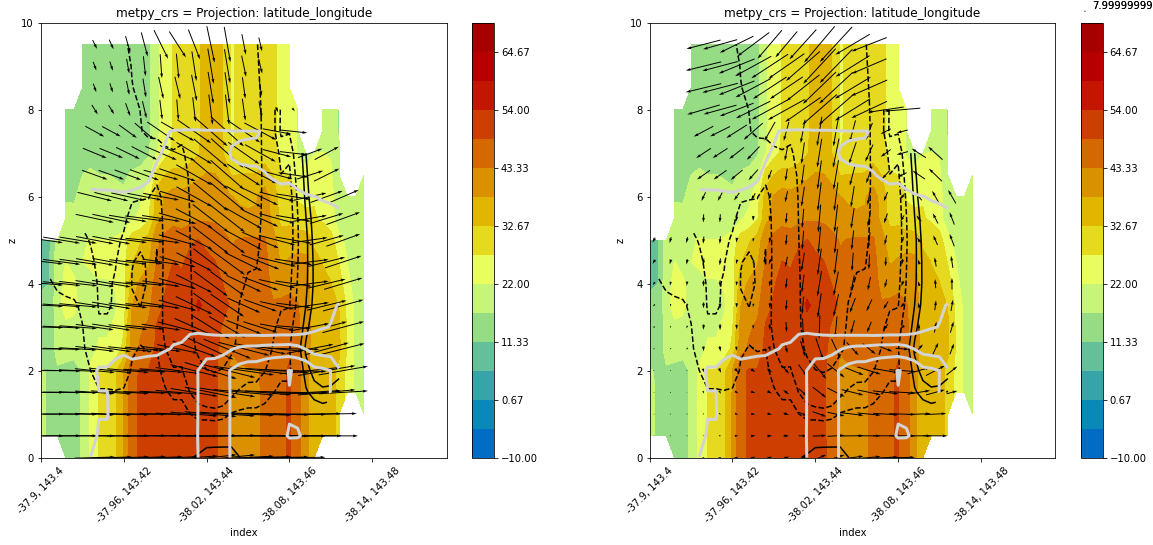

In [27]:
#Draw a cross section at a particular time

t="2020-01-31 03:42:00"
start = [-37.9,143.4]
end = [-38.2,143.5]

#Location of the downed transmission tower is shown. The AWS location is to the SE of that
cross_section_plot(rad_wnd,t,start,end,extra_points=[[143.79,-38.23],[143.6,-37.92]],preview_transect=False,storm_speed=23.659)

Re-gridding to regular lat-lon for each vertical level...


100%|██████████| 41/41 [00:15<00:00,  2.60it/s]


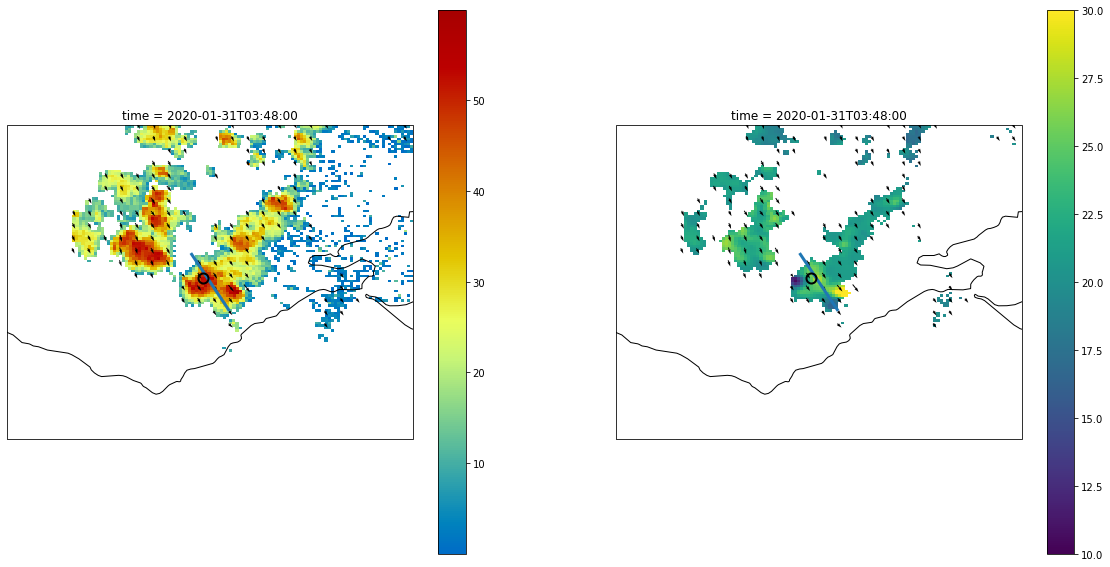

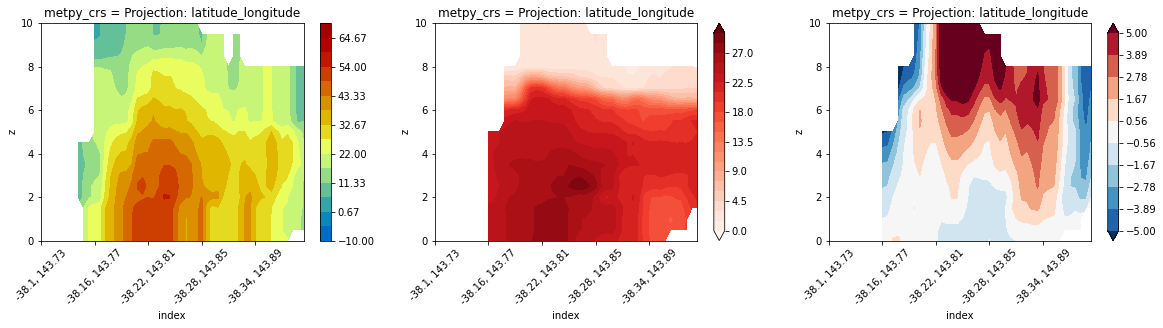

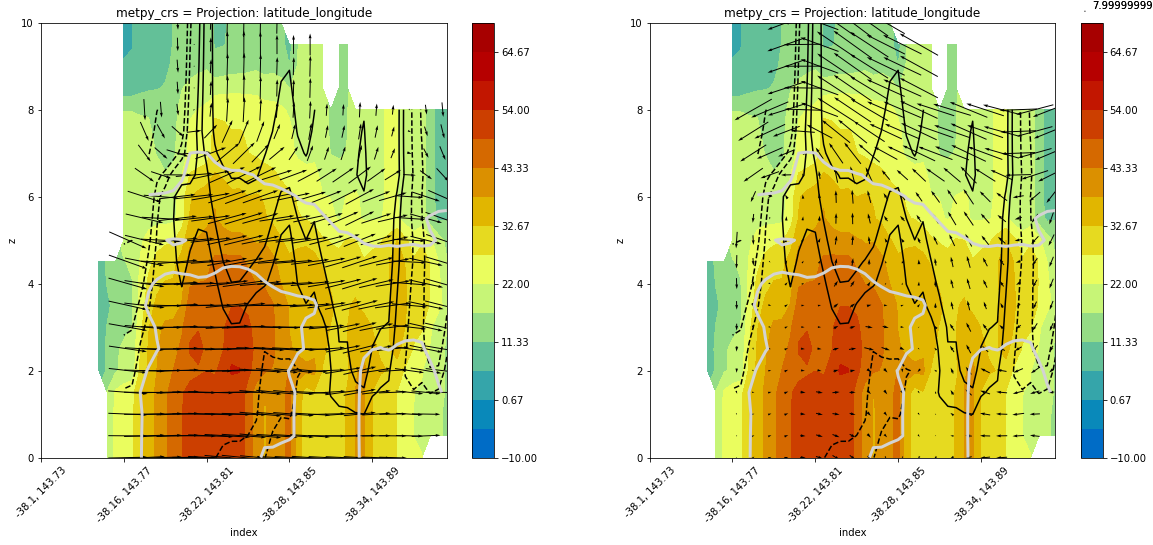

In [9]:
t="2020-01-31 03:48:00"
start = [-38.1,143.73]
end = [-38.4,143.93]

cross_section_plot(rad_wnd,t,start,end,extra_points=[[143.79,-38.23]],preview_transect=False,storm_speed=23.659) 

Re-gridding to regular lat-lon for each vertical level...


100%|██████████| 41/41 [00:15<00:00,  2.73it/s]


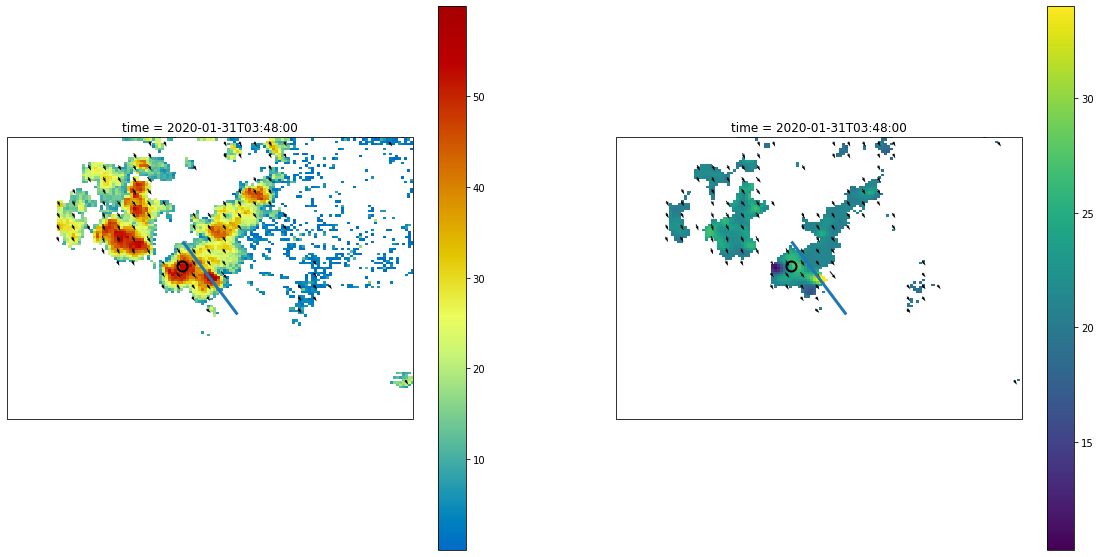

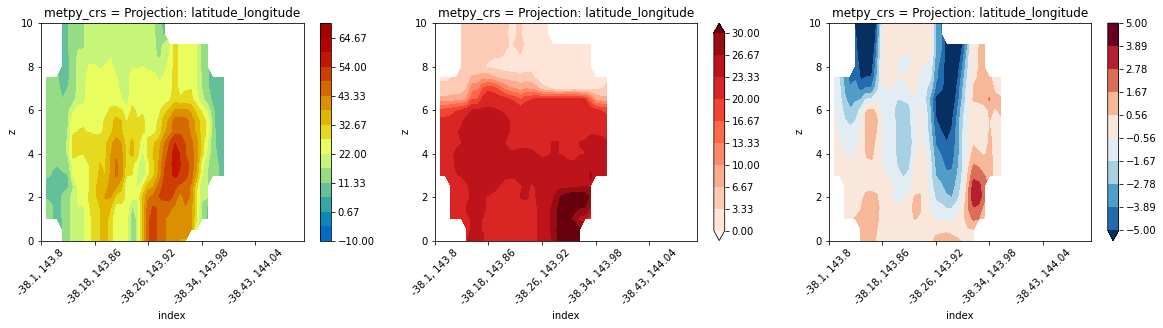

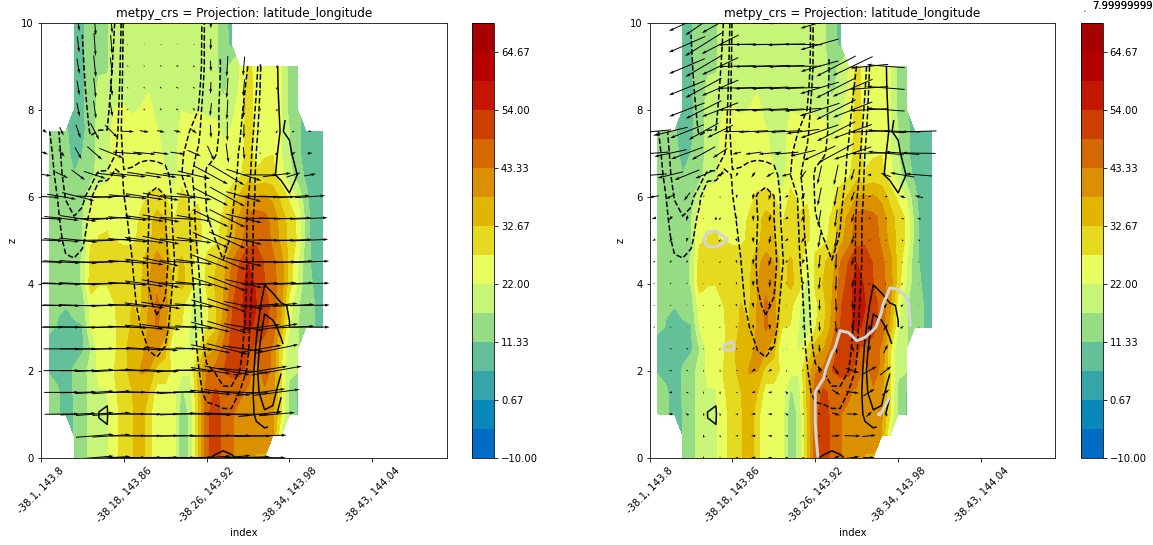

In [90]:
t="2020-01-31 03:48:00"
start = [-38.1,143.8]
end = [-38.5,144.1]

cross_section_plot(rad_wnd,t,start,end,extra_points=[[143.7924,-38.2332]],preview_transect=False,storm_speed=23.659) 

In [206]:
pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/2_scw_envs_df.csv").iloc[-10:][["dt_utc","gust","group_id","stn_id","uid10","speed"]]

,dt_utc,gust,group_id,stn_id,uid10,speed
75,2019-12-30 08:37:00,26.3,20191230083628/373,88166,393.0,25.132
76,2020-01-15 04:05:00,31.4,20200115040031/483,87113,483.0,7.897
77,2020-01-15 05:28:00,26.7,20200115052428/511,86398,511.0,15.280
78,2020-01-31 03:47:00,33.1,20200131034228/1287,90035,1287.0,23.659
79,2020-01-31 05:00:00,29.7,20200131045428/1307,86220,1307.0,23.440
80,2020-01-31 07:22:00,33.6,20200131071828/1317,90035,1317.0,27.289
81,2020-05-19 14:27:00,27.3,20200519142428/110,89002,114.0,33.616
82,2020-08-27 08:01:00,25.7,20200827080028/336,86068,335.0,NaN
83,2020-11-15 12:44:00,27.8,20201115124021/681,86398,681.0,41.550
84,2020-12-27 06:55:00,25.2,20201227065521/735,86398,742.0,22.396


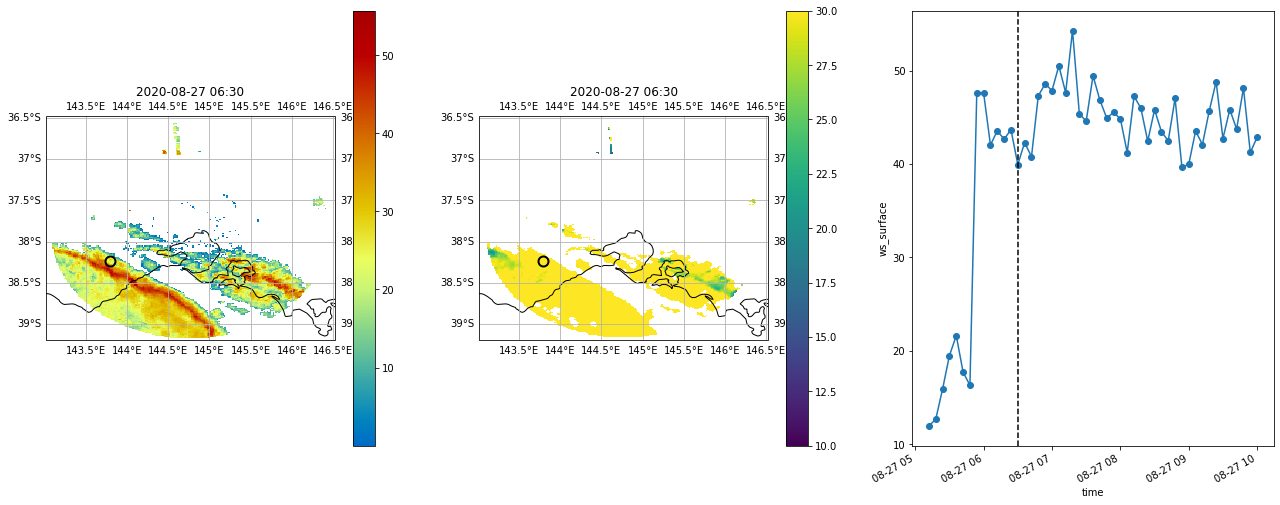

In [30]:
#Load the radar wind retrievals, and plot (reflectivity and surface wind speed) over the domain at a given time. Also, plot a time series of domain-max surface wind speed
rad_wnd = xr.open_mfdataset("/g/data/eg3/ab4502/Andrew_retrievals/20200827/2_20200827_*.nc",preprocess=preprocess)
plot_domain(rad_wnd,"2020-08-27 06:30",[[143.7924,-38.2332]]) 

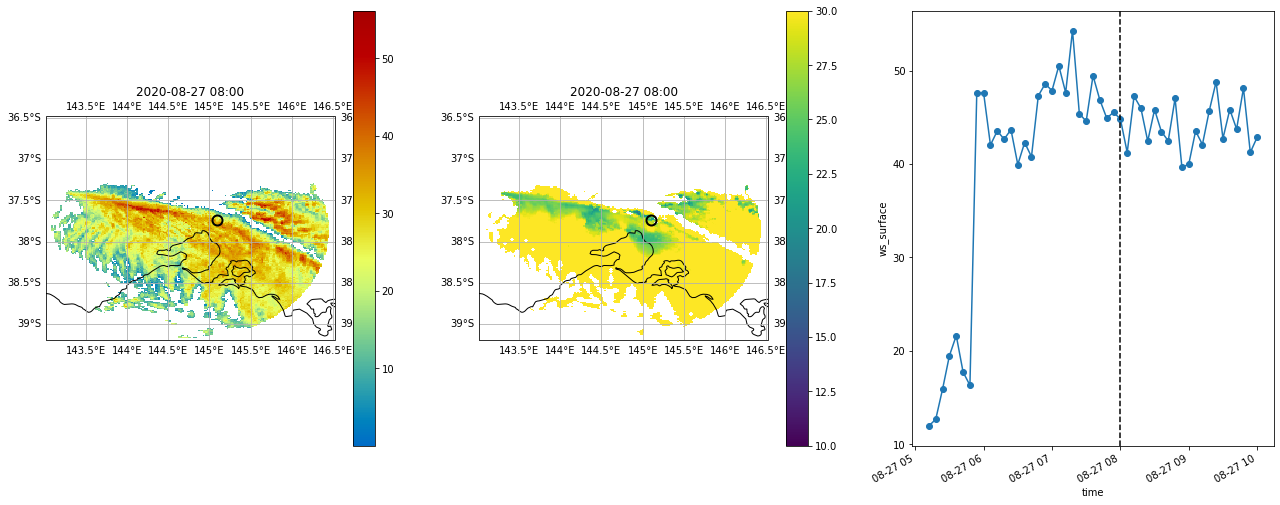

In [11]:
#Load the radar wind retrievals, and plot (reflectivity and surface wind speed) over the domain at a given time. Also, plot a time series of domain-max surface wind speed
#rad_wnd = xr.open_mfdataset("/g/data/eg3/ab4502/Andrew_retrievals/20200827/2_20200827_*.nc",preprocess=preprocess)
plot_domain(rad_wnd,"2020-08-27 08:00",[[145.0972,-37.7408]]) 

In [12]:
file_id = "2_20200801_20200831"
temp = pd.read_csv("/g/data/eg3/ab4502/TINTobjects/"+file_id+".csv")
print(temp.set_index(pd.DatetimeIndex(temp.time)).loc["2020-08-27 08:06"].uid)

time
2020-08-27 08:06:28    333
2020-08-27 08:06:28    322
2020-08-27 08:06:28    336
2020-08-27 08:06:28    337
Name: uid, dtype: int64


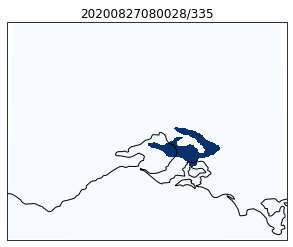

In [13]:
preview_storm("20200827080028/335",file_id)

1  time steps


1it [00:00,  8.31it/s]

Loading AWS data...


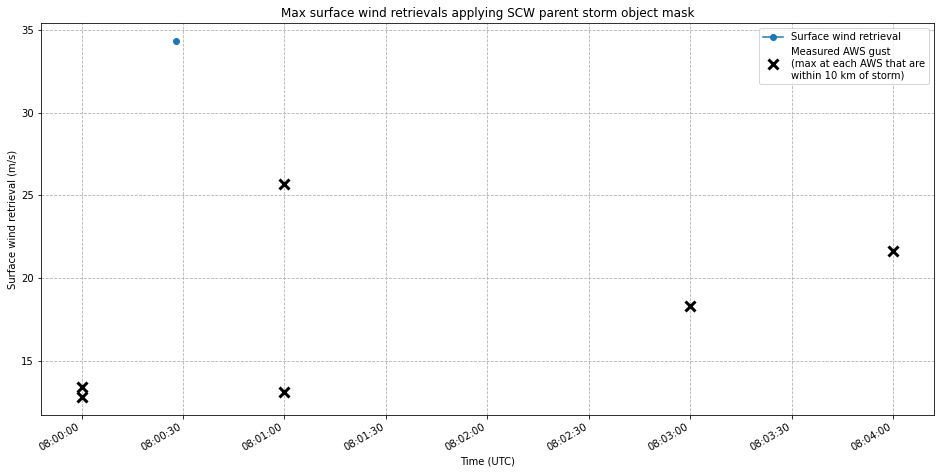

In [14]:
storm_track(rad_wnd,"20200827080028/335",file_id)

Re-gridding to regular lat-lon for each vertical level...


100%|██████████| 41/41 [00:14<00:00,  2.76it/s]


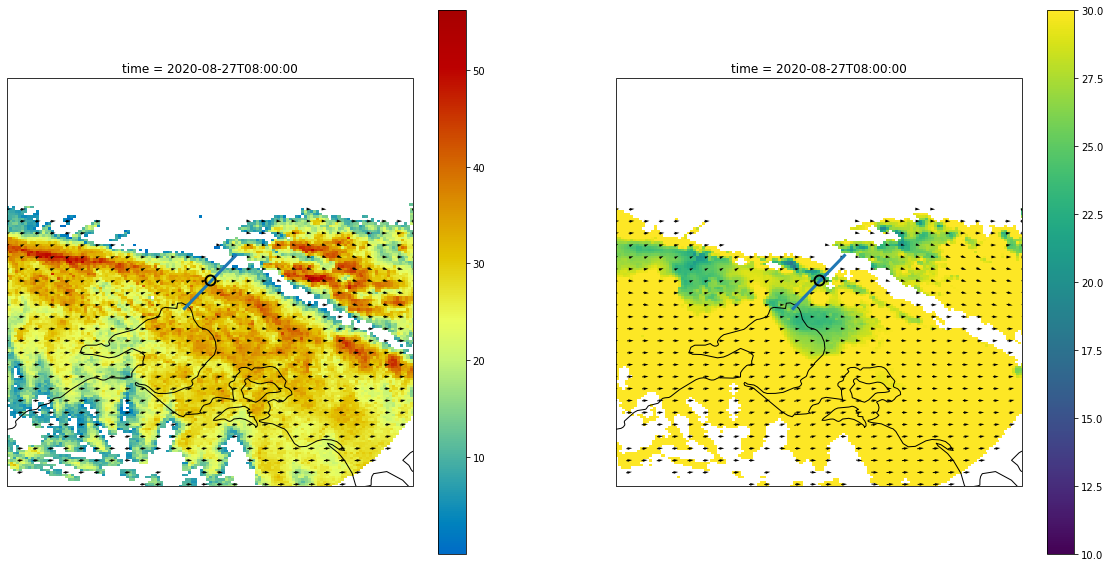

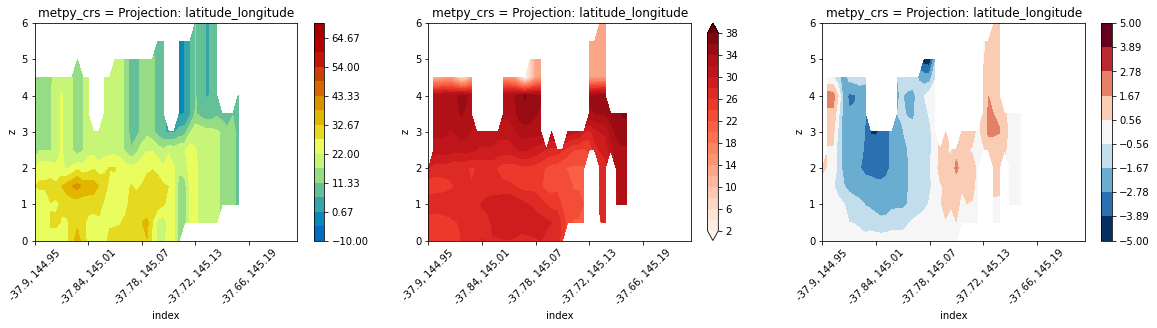

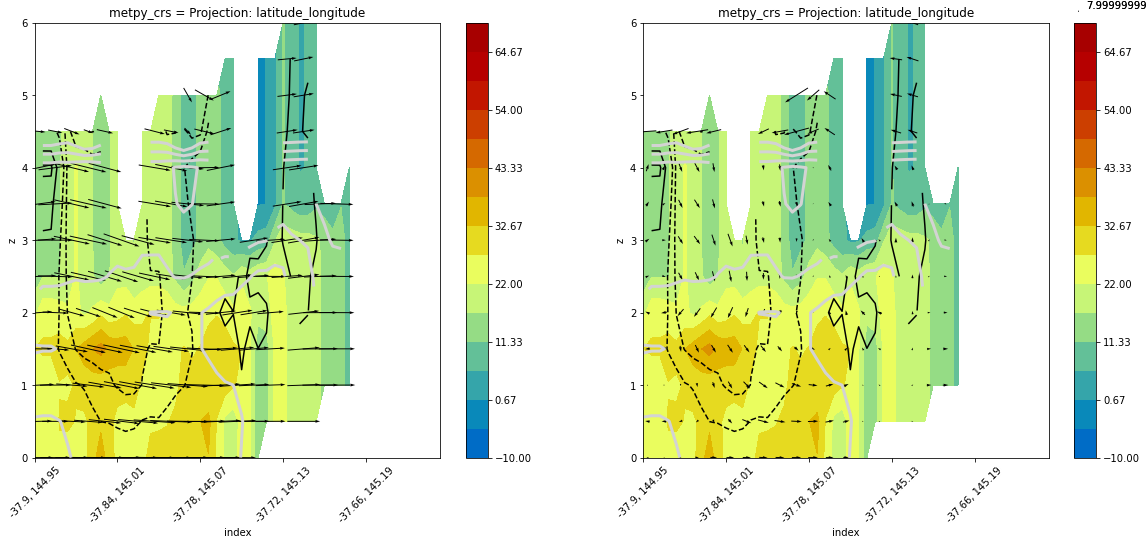

In [19]:
#Draw a cross section at a particular time

t="2020-08-27 08:00:00"
start = [-37.9,144.95]
end = [-37.6,145.24]

cross_section_plot(rad_wnd,t,start,end,extra_points=[[145.0972,-37.7408]],preview_transect=False,ymax=6)